In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

## Low dimensional moderator

In [2]:
import openmc
import NCrystal as NC
import NCrystal.plot as ncplot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

We will start by adding the NCMAT files for liquid hydrogen and deuterium from the Spallation Physics Group, from the [ESS SPG Gitlab Repository](https://git.esss.dk/spallation-physics-group/coldmoderators):

In [3]:
import urllib
import shutil

all_ncmat_files = [f.name for f in NC.browseFiles()]

new_files = {'ESS-oH2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidHydrogen/ESS-oH2-20K.ncmat',
             'ESS-pH2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidHydrogen/ESS-pH2-20K.ncmat',
             'ESS-oD2-19K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-oD2-19K.ncmat',
             'ESS-pD2-19K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-pD2-19K.ncmat',
             'ESS-oD2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-oD2-20K.ncmat',
             'ESS-pD2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-pD2-20K.ncmat'}

for file, url in new_files.items():
    if file not in all_ncmat_files:
        print(f'Retrieving {file}...')
        urllib.request.urlretrieve(url, file)
        shutil.copy2(file, os.environ['NCRYSTAL_DATADIR'])
        os.remove(file)

The `phases<X&Y>` syntaxis can be used to combine para and ortho hydrogen. This differs from the usual thermal scattering treatment in MCNP, PHITS, Serpent or OpenMC, where thermal scattering libraries are associated with a given nuclide, and pseudo-nuclides are required for hydrogen spin isomers:

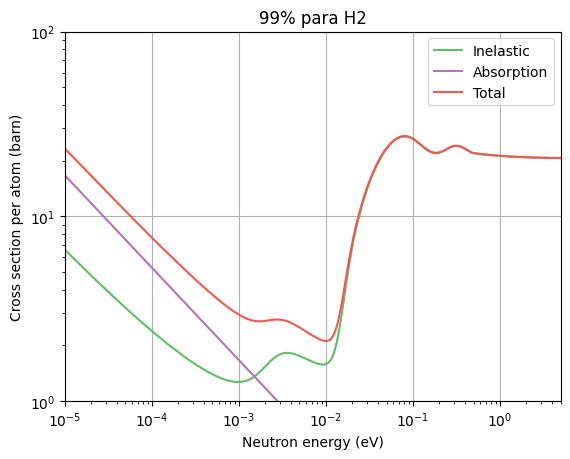

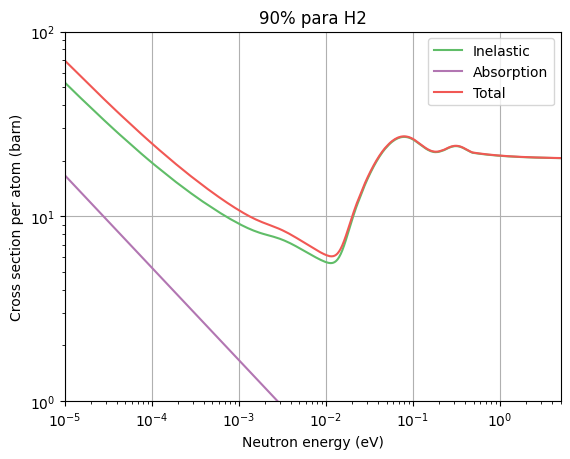

In [4]:
cfg99 = "phases<0.99*ESS-pH2-20K.ncmat&0.01*ESS-oH2-20K.ncmat>"
cfg90 = "phases<0.90*ESS-pH2-20K.ncmat&0.10*ESS-oH2-20K.ncmat>"
ncplot.plot_xsect(cfg99, mode='ekin', xmin=1e-5, xmax=5, ymin=1, ymax=100, title='99% para H2')
ncplot.plot_xsect(cfg90, mode='ekin', xmin=1e-5, xmax=5, ymin=1, ymax=100, title='90% para H2')

We will make a model consisting on a slab of cold moderator, with a layer of pre-moderator and boxes of thermal reflectors on top and bottom. To do this, it is handy to create a function that defines a box centered on a point and with given dimensions.

We could just make this box with `XPlane`, `YPlane` and `ZPlane` objects, but it is better to use `Plane` objects to make all the normals pointing outward, which makes easier to assign signs to the partial currents when we want to compute the leakage. We will also give names to the surfaces to make them easier to find later for the tallies:

In [5]:
def make_box(center=np.array([0,0,0]), length=10, width=10, height=10, name_prefix='box'):
    p01 = openmc.Plane(a=-1,      d=-(center[0]-length/2), name=name_prefix+'-x')
    p02 = openmc.XPlane(         x0=+(center[0]+length/2), name=name_prefix+'+x')
    p03 = openmc.Plane(a=0, b=-1, d=-(center[1]-width/2),  name=name_prefix+'-y')
    p04 = openmc.YPlane(         y0=+(center[1]+width/2),  name=name_prefix+'+y')
    p05 = openmc.Plane(a=0, c=-1, d=-(center[2]-height/2), name=name_prefix+'-z')
    p06 = openmc.ZPlane(         z0=+(center[2]+height/2), name=name_prefix+'+z')
    region = (-p01&-p02&-p03&-p04&-p05&-p06)
    return region

Using this helper function we can create our model easier. The function to create the model will take as a parameter the material to fill the cold moderator cell. We will use room temperature water as pre-moderator and beryllium as thermal reflector. 

In [6]:
def make_model(mod_mat, Moderator_height=5, NParticles=20000):

    Premoderator_thickness = 1 # cm
    Moderator_width = 20 # cm
    Moderator_length = 20 # cm

    Be_reflector_center = np.array([0,0,0]) # cm
    Be_reflector_width = 40 # cm
    Be_reflector_length = 40 # cm
    Be_reflector_height = Moderator_height + 2*Premoderator_thickness + 10 # cm
    Big_sphere_radius = 100 # cm

    cfg_Be = 'Be_sg194.ncmat'
    m2 = openmc.Material.from_ncrystal(cfg_Be)
    m2.name= cfg_Be

    cfg_H2O = 'LiquidWaterH2O_T293.6K.ncmat'
    m3 = openmc.Material.from_ncrystal(cfg_H2O)
    m3.name= cfg_H2O

    Be_box = make_box(Be_reflector_center,
                      Be_reflector_length,
                      Be_reflector_width,
                      Be_reflector_height)

    Mod_box = make_box(Be_reflector_center,
                       Moderator_length,
                       Moderator_width,
                       Moderator_height, name_prefix='mod')

    Premod_box = make_box(Be_reflector_center,
                          Moderator_length,
                          Moderator_width,
                          Moderator_height+2*Premoderator_thickness)

    Flight_box = make_box(Be_reflector_center,
                         Be_reflector_length,
                         Be_reflector_width,
                         Moderator_height+2*Premoderator_thickness)

    s99 = openmc.Sphere(r=Big_sphere_radius, boundary_type='vacuum')


    Moderator_Cell = openmc.Cell(region=Mod_box, fill=mod_mat)
    PreModerator_Cell = openmc.Cell(region=Premod_box&~Mod_box, fill=m3)
    FlightTube_Cell = openmc.Cell(region=Flight_box&~Moderator_Cell.region&~PreModerator_Cell.region, fill=None)
    Reflector_Cell = openmc.Cell(region=Be_box&
                                 ~(Moderator_Cell.region|PreModerator_Cell.region|FlightTube_Cell.region),fill=m2)
    Outside_Cell = openmc.Cell(region=-s99&
                                     ~(Moderator_Cell.region|
                                       PreModerator_Cell.region|
                                       FlightTube_Cell.region|
                                       Reflector_Cell.region), fill=None)


    uni = openmc.Universe(cells=[Moderator_Cell, PreModerator_Cell, FlightTube_Cell, Reflector_Cell, Outside_Cell])

    geo = openmc.Geometry(root=uni)

    settings = openmc.Settings()

    source1 = openmc.Source()
    source1.space = openmc.stats.Box(Be_reflector_center+np.array([-Be_reflector_length/2,-Be_reflector_width/2,+Be_reflector_height/2]),
                                     Be_reflector_center+np.array([+Be_reflector_length/2,+Be_reflector_width/2,+Be_reflector_height/2]))
    source1.angle = openmc.stats.Monodirectional(reference_uvw=[0,-1,0])
    source1.energy = openmc.stats.Discrete([1.0e3], [1.0])

    settings.source = [source1]

    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    # settings.temperature = {'method':'interpolation', 'multipole':True}
    settings.temperature = {'tolerance':1000, 'method':'nearest'}
    
    tally1 = openmc.Tally()
    filter11 = openmc.CellFilter([Moderator_Cell])
    filter12 = openmc.EnergyFilter(np.geomspace(1e-4, 100, 120))
    tally1.scores = ['flux']
    tally1.name = 'spectrum'
    tally1.filters = [filter11, filter12]

    tally2 = openmc.Tally()
    filter21 = openmc.CellFromFilter([Moderator_Cell])
    filter22 = openmc.SurfaceFilter(geo.get_surfaces_by_name('mod'))
    filter23 = openmc.CellFilter([FlightTube_Cell])
    filter24 = openmc.EnergyFilter([0,0.010])
    tally2.scores = ['current']
    tally2.name = 'cold leakage'
    tally2.filters = [filter21, filter22, filter23, filter24]
    
    tally3 = openmc.Tally()
    tally3.scores = ['current']
    tally3.name = 'leakage spectrum'
    tally3.filters = [filter21, filter22, filter23, filter12]

    tallies = openmc.Tallies([tally1, tally2, tally3])

    return openmc.model.Model(geometry=geo, settings=settings, tallies=tallies)

We can start the simulation with a 2-cm thick, 99% pure para-H2 moderator:

In [7]:
cfg = "phases<0.99*ESS-pH2-20K.ncmat&0.01*ESS-oH2-20K.ncmat>"
mat_h2_nc = openmc.Material.from_ncrystal(cfg)
mat_h2_nc.name= '99% para'

h2_height = 2
model = make_model(mat_h2_nc, h2_height, NParticles=200000)
model.export_to_xml()

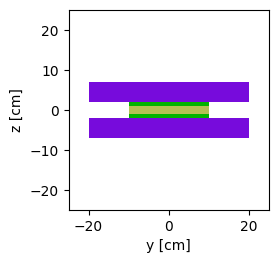

In [8]:
# Plot the geometry:
root = model.geometry.root_universe
root.plot(width=(50, 50), origin=[0, 0, 0], basis='yz', color_by='material')

In [9]:
!rm summary.h5 statepoint.10.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

We can plot the spectrum inside of the moderator cell:

Text(0, 0.5, 'Spectrum [au]')

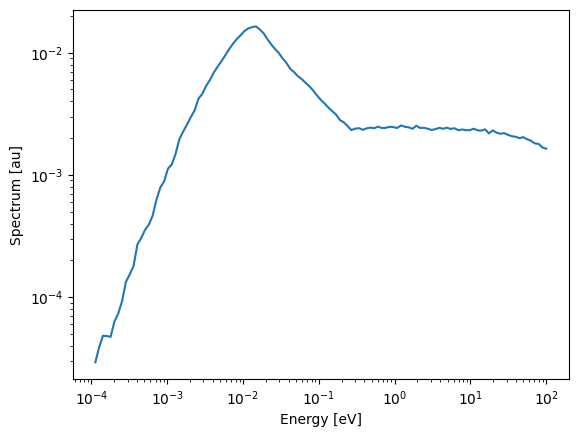

In [10]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(name='spectrum')
df = tally.get_pandas_dataframe()
phi_g = df['mean'].values
E_g = df['energy high [eV]'].values
plt.loglog(E_g, phi_g)
plt.xlabel('Energy [eV]')
plt.ylabel('Spectrum [au]')

To analyze the spectrum leaking from the source, we can use the method `Geometry.get_surfaces_by_name()` to find the surfaces (unless we fix their ID), and then use  `tally.get_slice()` to filter the spectra on each side of the moderator box:

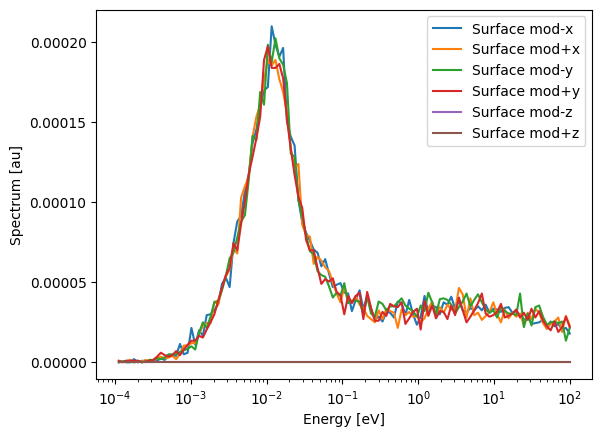

In [11]:
tally = sp.get_tally(name='leakage spectrum')
surfs = model.geometry.get_surfaces_by_name('mod')
for s in surfs:
    tally2 = tally.get_slice(filters=[openmc.SurfaceFilter], filter_bins=[(s.id,)])
    df = tally2.get_pandas_dataframe()
    phi_g = df['mean'].values
    E_g = df['energy high [eV]'].values
    plt.semilogx(E_g, phi_g, label=f'Surface {s.name}')
plt.xlabel('Energy [eV]')
plt.ylabel('Spectrum [au]')
plt.legend()

As expected, we get the same spectra for the surfaces perpendicular to the x and y axes due to symmetry. Spectra on the surfaces perpendicular to the z axis is zero, because we filtered out those events with the `CellFilter()` and `CellFromFilter()` filters.

We can then combine the results of the tallies using `tally.summation()`, and compute the average current density (or _spectral brightness_) by dividing by the total emission area:

Text(0, 0.5, 'Brightness [au]')

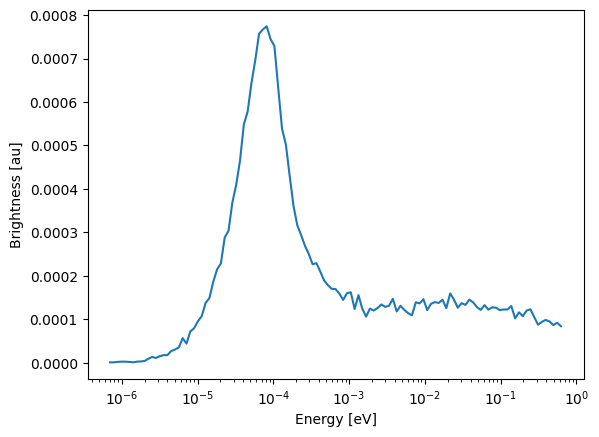

In [12]:
tally = sp.get_tally(name='leakage spectrum')
tally2 = tally.summation(filter_type=openmc.SurfaceFilter, remove_filter=True)
df = tally2.get_pandas_dataframe()
phi_g = df['mean'].values
E_g = df['energy high [eV]'].values/(4*h2_height*20)
plt.figure()
plt.semilogx(E_g, phi_g)
plt.xlabel('Energy [eV]')
plt.ylabel('Brightness [au]')

We can now repeat the calculation and look at the $(0,10)$ meV energy interval, defined in the `cold leakage` tally as a function of moderator thickness. We will use `tally.summation()` to accumulate the counts from all sides:

In [ ]:
mat_h2_nc = openmc.Material.from_ncrystal(cfg99)
mat_h2_nc.name= '99% para'
results = []
h2_heights = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for h in h2_heights:
    model = make_model(mat_h2_nc, h)
    model.export_to_xml()
    !rm summary.h5 statepoint.*.h5
    openmc.run(output=False)
    sp = openmc.StatePoint('statepoint.10.h5')
    tally = sp.get_tally(name='cold leakage')
    tally2 = tally.summation(filter_type=openmc.SurfaceFilter, remove_filter=True)
    df = tally2.get_pandas_dataframe()
    results.append(df['mean'].values/(4*h*20))
plt.plot(h2_heights, results, '.')
plt.xlabel('Moderator height [cm]')
plt.ylabel('Cold brightness [cm]')